In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
from matplotlib import gridspec
import scipy as sp

import time
import pickle
import re

import urllib.request
from bs4 import BeautifulSoup

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
mpl.__version__

'3.5.1'

In [3]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [4]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import *
from pubmed_landscape_src.exploration import (
    find_mask_words,
    print_tfidf_top_words,
    print_tfidf_threshold_words,
)

In [5]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
plt.style.use("matplotlib_style.txt")

# Import

In [117]:
# import clean_df_updated
clean_df_updated_reparsed_filtered = pd.read_pickle(
    berenslab_data_path
    / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

tcmalloc: large alloc 1073741824 bytes == 0x8b8b04000 @ 
tcmalloc: large alloc 1233903616 bytes == 0x962ab2000 @ 
tcmalloc: large alloc 2147483648 bytes == 0x9acb70000 @ 
tcmalloc: large alloc 1542381568 bytes == 0x8b8b04000 @ 
tcmalloc: large alloc 1927979008 bytes == 0x927d4e000 @ 


In [118]:
pmids_dataset = clean_df_updated_reparsed_filtered.PMID.to_numpy()

In [119]:
all_abstracts = clean_df_updated_reparsed_filtered.AbstractText

In [120]:
tsne_reparsed = np.load(variables_path / "tsne_reparsed.npy")

In [121]:
tsne = np.vstack((-tsne_reparsed[:, 0], tsne_reparsed[:, 1])).T

In [122]:
mask_retracted_pmids = np.load(variables_path / "mask_retracted_pmids.npy")

In [255]:
mask_new_retracted_pmids = np.load(variables_path / "mask_new_retracted_pmids.npy")

# Retracted papers

## Scrape PMIDs 

In [239]:
%%time
retracted_pmids_desc = []

for page in range(1, 50):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?size="
        + size
        + "&page="
        + page
        + "&term=%22Retracted+Publication%22[pt]&sort=date&sort_order=desc&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_desc.append(soup.get_text().split()[7:])

retracted_pmids_desc = np.hstack(retracted_pmids_desc)

CPU times: user 831 ms, sys: 68 ms, total: 899 ms
Wall time: 44.9 s


In [17]:
np.save(variables_path / "retracted_pmids_desc", retracted_pmids_desc)

In [240]:
%%time
retracted_pmids_asc = []

for page in range(1, 21):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?size="
        + size
        + "&page="
        + page
        + "&term=%22Retracted+Publication%22[pt]&sort=date&sort_order=asc&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_asc.append(soup.get_text().split()[7:])

retracted_pmids_asc = np.hstack(retracted_pmids_asc)

CPU times: user 333 ms, sys: 29 ms, total: 362 ms
Wall time: 18 s


In [19]:
np.save(variables_path / "retracted_pmids_asc", retracted_pmids_asc)

In [241]:
retracted_pmids_asc = np.load(variables_path / "retracted_pmids_asc.npy")
retracted_pmids_desc = np.load(variables_path / "retracted_pmids_desc.npy")

In [218]:
retracted_pmids = np.unique(
    np.hstack((retracted_pmids_desc, retracted_pmids_asc))
)
retracted_pmids.shape

(13569,)

In [224]:
np.save(variables_path / "retracted_pmids", retracted_pmids)

## Retraction watch PMIDs

In [7]:
retraction_watch_data = pd.read_csv("../data/retractions.csv")

In [94]:
retraction_watch_data.columns

Index(['Record ID', 'Title', 'Subject', 'Institution', 'Journal', 'Publisher',
       'Country', 'Author', 'URLS', 'ArticleType', 'RetractionDate',
       'RetractionDOI', 'RetractionPubMedID', 'OriginalPaperDate',
       'OriginalPaperDOI', 'OriginalPaperPubMedID', 'RetractionNature',
       'Reason', 'Paywalled', 'Notes', 'Approved Status'],
      dtype='object')

In [95]:
print(
    f"There are {np.sum(retraction_watch_data.OriginalPaperPubMedID != 0)} retracted papers with PMIDs != 0"
)

There are 25382 retracted papers with PMIDs != 0


In [96]:
retracted_pmids_rw = retraction_watch_data["OriginalPaperPubMedID"][
    retraction_watch_data["OriginalPaperPubMedID"] != 0
]

### NaNs exploration

In [98]:
print(f"There are {np.sum(np.isnan(retracted_pmids_rw.to_numpy()))} NaNs")

There are 5194 NaNs


In [99]:
retraction_watch_data.loc[
    retracted_pmids_rw[np.isnan(retracted_pmids_rw.to_numpy())].index
]

,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,ArticleType,...,RetractionDOI,RetractionPubMedID,OriginalPaperDate,OriginalPaperDOI,OriginalPaperPubMedID,RetractionNature,Reason,Paywalled,Notes,Approved Status
4319,43186,Optimized intelligent data management framewor...,(B/T) Business - Manufacturing;(B/T) Computer ...,"Department of Computer Science, College of Com...",Complex & Intelligent Systems,Springer,Saudi Arabia,Abdulmajeed Alsufyani;Youseef Alotaibi;Alaa Om...,NaN,Research Article;,...,10.1007/s40747-021-00511-w,NaN,8/30/2021 0:00,10.1007/s40747-021-00511-w,NaN,Retraction,+Fake Peer Review;+Investigation by Journal/Pu...,No,NaN,Approved by Admin on Mar 12 2023 7:51PM
4320,43185,Towards secure deep learning architecture for ...,(B/T) Computer Science;(B/T) Technology;(BLS) ...,Department of Computer Science and Engineering...,Complex & Intelligent Systems,Springer,India,R Udendhran;M Balamurugan,NaN,Research Article;,...,10.1007/s40747-022-00935-y,NaN,11/10/2020 0:00,10.1007/s40747-020-00225-5,NaN,Retraction,+Fake Peer Review;+Investigation by Journal/Pu...,No,NaN,Approved by Admin on Mar 12 2023 7:51PM
17813,29627,Assessment of the lynchial development of an a...,(SOC) Education;,"Associate Professor, Department of Pedagogy an...",Education and Science (ÐÐ±ÑÐ°Ð·Ð¾Ð²Ð°Ð½Ð¸Ðµ ...,Russian State Vocational Pedagogical Universit...,Russia,Natalia Alekseevna (ÐÐ°ÑÐ°Ð»ÑÑ ÐÐ»ÐµÐºÑÐ...,NaN,Research Article;,...,Unavailable,NaN,1/1/2016 0:00,10.17853/1994-5639-2016-6-141-151,NaN,Retraction,+Duplication of Article;,No,NaN,Approved by Admin on Jun 16 2021 2:03PM
20813,26619,Biosoption of chromium(VI) from aqueous soluti...,(BLS) Biochemistry;(PHY) Chemistry;,School of Municipal and Environmental Engineer...,2011 5th International Conference on Bioinform...,IEEE: Institute of Electrical and Electronics ...,China,Chun Guang Yu;Mao An Du;Zhao Hui Meng;Jin Miao...,http://retractionwatch.com/2015/06/25/one-publ...,Conference Abstract/Paper;,...,10.1109/icbbe.2011.5781194,0.0,5/10/2011 0:00,10.1109/icbbe.2011.5781194,NaN,Retraction,+Notice - Limited or No Information;,No,NaN,Approved by Admin on Jun 28 2023 1:38PM
30489,16894,Critical radius for radial heat conduction: a ...,(PHY) Energy;(PHY) Engineering - Mechanical;(P...,Mechanical Engineering and Energy Processes De...,Applied Thermal Engineering,Elsevier,United States,M R Kulkarni,NaN,Research Article;,...,10.1016/j.applthermaleng.2003.08.017,NaN,12/13/2003 0:00,10.1016/j.applthermaleng.2003.08.017,NaN,Retraction,+Duplication of Article;+Euphemisms for Duplic...,No,NaN,Approved by Admin on Jan 19 2018 10:09AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46337,859,Therapeutic window of stem cell potential for ...,(BLS) Biology - Cancer;(BLS) Biology - Cellula...,Neuro-Oncology Research Laboratory Center for ...,Stem Cell Reviews,Springer,United States,ShengwenÂ Calvin Li;Yuan-Ping Han;BrentÂ A Det...,NaN,Review Article;,...,10.1007/s12015-009-9066-0,19590989.0,4/23/2009 0:00,NaN,NaN,Retraction,+Error by Journal/Publisher;,Unknown,NaN,Approved by Admin on Jan 30 2017 2:35PM
46419,776,"Ring expansion of a 4,4'-bipyridyl derivative ...",(PHY) Chemistry;,"Department of Material Science, Faculty of Sci...",Angewandte Chemie,Wiley,Japan,Isao Yamaguchi;Saori Tsutsui;Moriyuki Sato,NaN,Research Article;,...,10.1002/ange.200790137,17604376.0,3/30/2007 0:00,10.1002/anie.200700170,NaN,Retraction,+Error in Data;,No,No PMID for article; 2/21/2017,Approved by Admin on Feb 21 2017 2:05PM
46439,756,"Controversial issues: compartment syndrome, te...",(HSC) Medicine - Anesthesia/Anaesthesia;,Department of Pediatric Anesthesiology and Int...,Pediatric Anesthesia (Paediatric Anaesthesia),Wiley,Italy,Valeria Mossetti;Giorgio Ivani,NaN,Review Article;,...,NaN,NaN,7/2/2011 0:00,10.1111/j.1460-9592.2011.03648.x,NaN,Retraction,+Duplication of Article;,No,NaN,Approved by Admin on Apr 25 2018 8:54PM
46633,561,Surgical Management of

In [100]:
retracted_pmids_rw_clean = retracted_pmids_rw[
    ~np.isnan(retracted_pmids_rw.to_numpy())
]
print(
    f"There are actually {len(retracted_pmids_rw_clean)} retracted papers with PMIDs"
)

There are actually 20188 retracted papers with PMIDs


### Check for duplicates

In [101]:
retracted_pmids_rw_clean

0        32264640.0
1        32262521.0
2        23151593.0
3        27341836.0
4        37067550.0
            ...    
47180      217854.0
47181     1791149.0
47182     2372964.0
47183    21278292.0
47184    18636547.0
Name: OriginalPaperPubMedID, Length: 20188, dtype: float64

In [102]:
unique_retracted_pmids_rw_clean = np.unique(retracted_pmids_rw_clean)
print(
    f"There are {len(unique_retracted_pmids_rw_clean)} unique retracted PMIDs"
)

There are 18786 unique retracted PMIDs


#### Sanity check

In [103]:
values, counts = np.unique(retracted_pmids_rw_clean, return_counts=True)

In [104]:
print(len(values))
print(len(counts))
values[counts > 1]

18786
18786


array([ 1341533.,  1518830.,  2141811., ..., 35940183., 36608046.,
       37013495.])

In [105]:
retraction_watch_data[retraction_watch_data.OriginalPaperPubMedID == 1341533.0]

,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,ArticleType,...,RetractionDOI,RetractionPubMedID,OriginalPaperDate,OriginalPaperDOI,OriginalPaperPubMedID,RetractionNature,Reason,Paywalled,Notes,Approved Status
44195,3053,Laparoscopic segmental resection for infiltrat...,(HSC) Medicine - Obstetrics/Gynecology;(HSC) M...,"Center for Special Pelvic Surgery, Atlanta, Ge...","Surgical Laparoscopy, Endoscopy & Percutaneous...",Lippincott Williams and Wilkins,United States,Camran Nezhat;Farr Nezhat;Earl Pennington;Wayn...,NaN,Clinical Study;,...,NaN,NaN,9/1/1992 0:00,NaN,1341533.0,Expression of concern,+Civil Proceedings;+Concerns/Issues About Data...,Yes,NO PMID for Notice. No DOIs for Original Artic...,Approved by Admin on May 18 2017 2:35PM
44295,2951,Laparoscopic segmental resection for infiltrat...,(HSC) Medicine - Obstetrics/Gynecology;(HSC) M...,"Center for Special Pelvic Surgery, Atlanta, Ge...","Surgical Laparoscopy, Endoscopy & Percutaneous...",Lippincott Williams and Wilkins,United States,Camran Nezhat;Farr Nezhat;Earl Pennington;Wayn...,NaN,Clinical Study;,...,NaN,11440025.0,9/1/1992 0:00,NaN,1341533.0,Retraction,+Civil Proceedings;+Concerns/Issues About Resu...,Yes,NaN,Approved by Admin on May 18 2017 2:44PM


### Transform to string

In [106]:
unique_retracted_pmids_rw_clean_str = np.array(
    [str(int(elem)) for elem in unique_retracted_pmids_rw_clean.tolist()]
)
print(
    f"There are {len(unique_retracted_pmids_rw_clean_str)} unique retracted PMIDs"
)

There are 18786 unique retracted PMIDs


In [210]:
np.save(
    variables_path / "unique_retracted_pmids_rw_clean_str",
    unique_retracted_pmids_rw_clean_str,
)

#### Sanity check

In [107]:
len(unique_retracted_pmids_rw_clean)

18786

In [108]:
len(
    np.unique(
        np.array(
            [int(elem) for elem in unique_retracted_pmids_rw_clean.tolist()]
        )
    )
)

18786

### Check how many of them are there in the scraped ids

In [109]:
retracted_pmids = np.load(variables_path / "retracted_pmids.npy")

In [110]:
retracted_pmids

array(['10026173', '10047653', '10050223', ..., '9931130', '9933281',
       '9987036'], dtype='<U8')

In [112]:
print(
    f"The old set has {len(set(retracted_pmids).difference(set(unique_retracted_pmids_rw_clean_str)))} papers that are not in the new set"
)
print(
    f"The new set has {len(set(unique_retracted_pmids_rw_clean_str).difference(set(retracted_pmids)))} papers that are not in the old set"
)

The old set has 481 papers that are not in the new set
The new set has 5698 papers that are not in the old set


In [252]:
print(
    f"The old set has {len(set(pmids_dataset[mask_retracted_pmids]).difference(set(pmids_dataset[mask_retracted_pmids_rw])))} papers that are not in the new set, contained in our dataset"
)
print(
    f"The new set has {len(set(pmids_dataset[mask_retracted_pmids_rw]).difference(set(pmids_dataset[mask_retracted_pmids])))} papers that are not in the old set, contained in our dataset"
)

The old set has 234 papers that are not in the new set, contained in our dataset
The new set has 3901 papers that are not in the old set, contained in our dataset


#### Sanity check

In [124]:
# set(retracted_pmids).difference(set(unique_retracted_pmids_rw_clean_str))

In [126]:
clean_df_updated_reparsed_filtered[
    clean_df_updated_reparsed_filtered.PMID
    == np.array(
        set(retracted_pmids).difference(
            set(unique_retracted_pmids_rw_clean_str)
        )
    )
]

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename


In [127]:
print(
    f"The old set has {len(set(retracted_pmids).difference(set(pmids_dataset)))} papers that are not in the dataset we use"
)
print(
    f"The new set has {len(set(unique_retracted_pmids_rw_clean_str).difference(set(pmids_dataset)))} papers that are not in the dataset we use"
)

The old set has 1582 papers that are not in the dataset we use
The new set has 3132 papers that are not in the dataset we use


In [176]:
13569 - 11998

1571

In [ ]:
print(len(np.unique(pmids_dataset[mask_retracted_pmids])))

11987


## Difference (only new PMIDs)

In [224]:
retracted_pmids = np.load(variables_path / "retracted_pmids.npy")

In [210]:
unique_retracted_pmids_rw_clean_str = np.load(
    variables_path / "unique_retracted_pmids_rw_clean_str.npy"
)

In [231]:
print(
    f"The new set has {len(set(pmids_dataset[mask_retracted_pmids_rw]).difference(set(pmids_dataset[mask_retracted_pmids])))} papers that are not in the old set, contained in our dataset"
)

The new set has 3901 papers that are not in the old set, contained in our dataset


In [232]:
print(
    f"The new set has {len(set(np.unique(pmids_dataset[mask_retracted_pmids_rw])).difference(set(np.unique(pmids_dataset[mask_retracted_pmids]))))} papers that are not in the old set, contained in our dataset"
)

The new set has 3901 papers that are not in the old set, contained in our dataset


In [211]:
print(
    f"The new set has {len(set(unique_retracted_pmids_rw_clean_str).difference(set(retracted_pmids)))} papers that are not in the old set"
)

The new set has 5698 papers that are not in the old set


In [213]:
new_retracted_pmids = set(unique_retracted_pmids_rw_clean_str).difference(
    set(retracted_pmids)
)

In [223]:
np.save(
    variables_path / "new_retracted_pmids", np.array(list(new_retracted_pmids))
)

# Mask

## Scraped

### Super slow solution

In [ ]:
%%time
mask_retracted_pmids_test = np.isin(pmids_dataset, retracted_pmids)

CPU times: user 1h 16min 41s, sys: 1min 40s, total: 1h 18min 21s
Wall time: 1h 18min 19s


In [ ]:
np.sum(mask_retracted_pmids_test)

11998

### Good solution

In [251]:
%%time
dict_map = dict()
for elem in retracted_pmids:
    dict_map[elem] = 1

CPU times: user 5.07 ms, sys: 1 ms, total: 6.07 ms
Wall time: 6.05 ms


In [252]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 1.28 s, sys: 915 µs, total: 1.28 s
Wall time: 1.28 s


In [253]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 968 ms, sys: 23 µs, total: 968 ms
Wall time: 968 ms


In [254]:
mask_retracted_pmids = pre_mask == 1

In [255]:
np.save(variables_path / "mask_retracted_pmids", mask_retracted_pmids)

## Retraction watch

In [151]:
%%time
dict_map = dict()
for elem in unique_retracted_pmids_rw_clean_str:
    dict_map[elem] = 1

CPU times: user 16.2 ms, sys: 60 µs, total: 16.2 ms
Wall time: 16 ms


In [152]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 2.23 s, sys: 262 ms, total: 2.49 s
Wall time: 2.48 s


In [153]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 799 ms, sys: 44.9 ms, total: 844 ms
Wall time: 840 ms


In [154]:
mask_retracted_pmids_rw = pre_mask == 1

In [200]:
np.sum(mask_retracted_pmids_rw)

15666

In [255]:
np.save(variables_path / "mask_retracted_pmids_rw", mask_retracted_pmids_rw)

## Difference (only new PMIDs)

In [216]:
type(new_retracted_pmids)

set

In [217]:
%%time
dict_map = dict()
for elem in new_retracted_pmids:
    dict_map[elem] = 1

CPU times: user 2.1 ms, sys: 4 µs, total: 2.1 ms
Wall time: 2.12 ms


In [218]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 1.06 s, sys: 4.01 ms, total: 1.06 s
Wall time: 1.06 s


In [219]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 962 ms, sys: 3.99 ms, total: 966 ms
Wall time: 963 ms


In [220]:
mask_new_retracted_pmids = pre_mask == 1

In [233]:
np.sum(mask_new_retracted_pmids)

3902

In [222]:
np.save(variables_path / "mask_new_retracted_pmids", mask_new_retracted_pmids)

# Mentions in the abstract
We extract the papers that mention the following words ("retracted", "retraction", "withdrawal") in the abstract to exclude them from the plot. We want to highlight only retracted papers that do not explicitly state in their abstract that they have been retracted.

## Scraped

In [188]:
abstracts = all_abstracts[mask_retracted_pmids]

In [189]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted)[0]),
)

Number of papers with uncapitalized word ' retracted':  160
Number of papers with capitalized word 'Retracted':  10
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  160


In [191]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction)[0]),
)

Number of papers with uncapitalized word ' retraction':  42
Number of papers with capitalized word 'Retraction':  12
Number of papers with uppercased word 'RETRACTION':  0
Number of total papers with retraction:  46


In [192]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  43
Number of papers with capitalized word 'Withdrawal':  146
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  187


In [193]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  34
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  34


In [194]:
print(
    f"There are {np.sum((~mask_retraction)& (~mask_retracted)& (~mask_withdrawal)& (~mask_withdrawn))} intact papers"
)

There are 11756 intact papers


## Retraction watch

In [177]:
abstracts = all_abstracts[mask_retracted_pmids_rw]

In [181]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted_rw)[0]),
)

Number of papers with uncapitalized word ' retracted':  243
Number of papers with capitalized word 'Retracted':  10
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  243


In [183]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction_rw)[0]),
)

Number of papers with uncapitalized word ' retraction':  95
Number of papers with capitalized word 'Retraction':  27
Number of papers with uppercased word 'RETRACTION':  1
Number of total papers with retraction:  104


In [184]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal_rw)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  86
Number of papers with capitalized word 'Withdrawal':  349
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  430


In [185]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn_rw)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  220
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  220


In [186]:
print(
    f"There are {np.sum((~mask_retraction_rw)& (~mask_retracted_rw)& (~mask_withdrawal_rw)& (~mask_withdrawn_rw))} intact papers"
)

There are 15103 intact papers


## Difference (only new PMIDs)

In [224]:
abstracts = all_abstracts[mask_new_retracted_pmids]

In [225]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted_new)[0]),
)

Number of papers with uncapitalized word ' retracted':  85
Number of papers with capitalized word 'Retracted':  0
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  85


In [226]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction_new)[0]),
)

Number of papers with uncapitalized word ' retraction':  55
Number of papers with capitalized word 'Retraction':  16
Number of papers with uppercased word 'RETRACTION':  1
Number of total papers with retraction:  60


In [227]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal_new)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  44
Number of papers with capitalized word 'Withdrawal':  208
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  249


In [228]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn_new)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  191
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  191


In [230]:
print(
    f"There are {np.sum((~mask_retraction_new)& (~mask_retracted_new)& (~mask_withdrawal_new)& (~mask_withdrawn_new))} intact papers"
)

There are 3572 intact papers


## Intact PMIDs

In [45]:
intact_retracted_pmids = pmids_dataset[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]
print(intact_retracted_pmids.shape)
np.save(variables_path / "intact_retracted_pmids", intact_retracted_pmids)

(11756,)


In [255]:
print(pmids_dataset.shape)
print(tsne.shape)

(20687150,)
(20687150, 2)


In [195]:
intact_retracted_pmids_rw = pmids_dataset[mask_retracted_pmids_rw][
    (~mask_retraction_rw)
    & (~mask_retracted_rw)
    & (~mask_withdrawal_rw)
    & (~mask_withdrawn_rw)
]
print(intact_retracted_pmids_rw.shape)
np.save(
    variables_path / "intact_retracted_pmids_rw", intact_retracted_pmids_rw
)

(15103,)


In [253]:
intact_new_retracted_pmids = pmids_dataset[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]
print(intact_new_retracted_pmids.shape)
np.save(
    variables_path / "intact_new_retracted_pmids", intact_new_retracted_pmids
)

(3572,)


# Plot

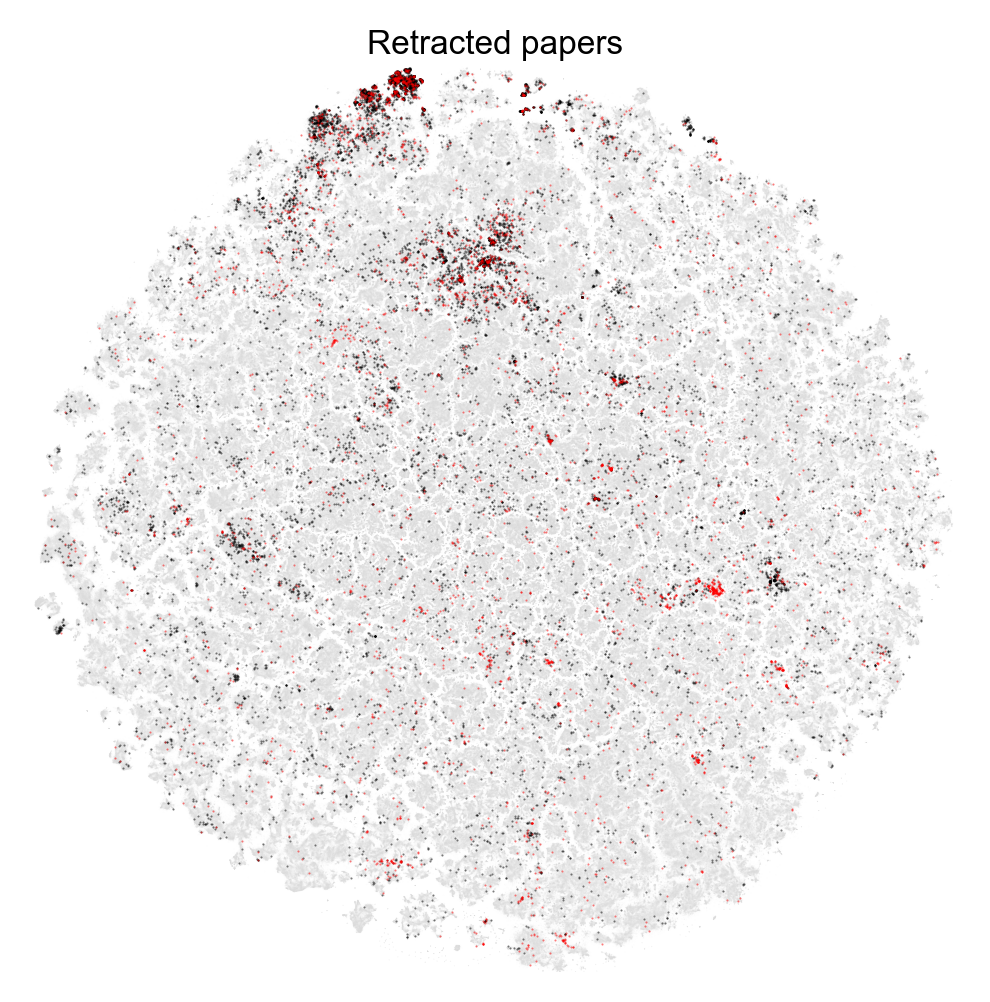

In [234]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

# subplot b
x_lim = (-220, 220)
y_lim = (-220, 220)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)


ax.scatter(
    *subregion.T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax.scatter(
    *subregion_rw.T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax.set_title("Retracted papers")
ax.axis("equal")
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])
ax.axis("off")

fig.savefig(figures_path / "retracted_papers_plus_rw_v3.png")

In [250]:
# with the new data

print(f"There are {tsne.shape[0]} papers")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

print(
    "Number of retracted papers: ",
    subregion.shape[0] + subregion_rw.shape[0],
)
print(
    "Fraction of retracted papers: ",
    (subregion.shape[0] + subregion_rw.shape[0]) / tsne.shape[0] * 100,
)

There are 20687150 papers
Number of retracted papers:  15328
Fraction of retracted papers:  0.0740943049187539


In [242]:
11756 + 3572

15328

## First inset

In [235]:
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.linewidth"] = 0.5

(200.0, 220.0)

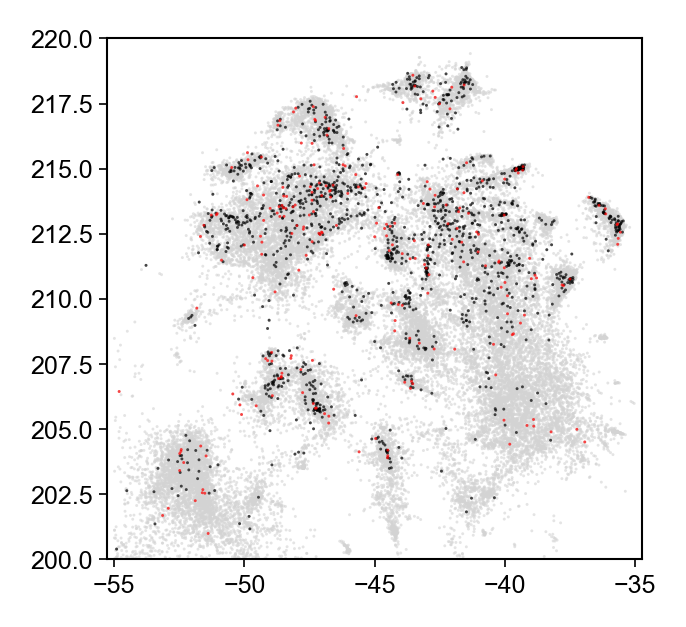

In [237]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

right = -35
left = -55
top = 220
bottom = 200

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.set_xticks([])
# ax1.set_yticks([])

In [266]:
# mask island 1, ONLY PubMed flagged papers
right = -35
left = -55
top = 220
bottom = 200
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 38252 papers in the zoom
There are 36899 non-retracted papers in the zoom
Number of retracted papers:  1353
Fraction of retracted papers:  3.537069957126425


In [267]:
# mask island 1, with the new data
right = -35
left = -55
top = 220
bottom = 200
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 38252 papers in the zoom
There are 36661 non-retracted papers in the zoom
Number of retracted papers:  1591
Fraction of retracted papers:  4.159259646554428


## Second inset

(214.5, 215.5)

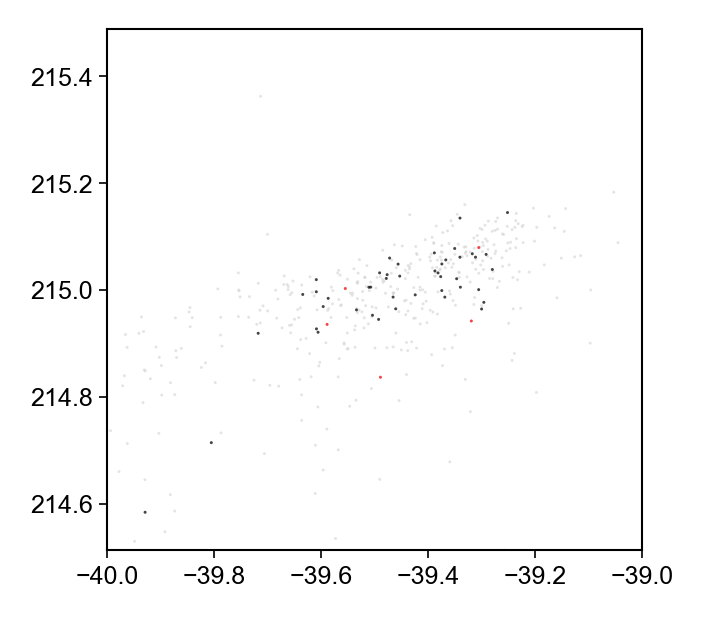

In [265]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

right = -39
left = -40
top = 215.5
bottom = 214.5

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.grid()

In [268]:
# mask island 1
right = -39
left = -40
top = 215.5
bottom = 214.5
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 422 papers in the zoom
There are 377 non-retracted papers in the zoom
Number of retracted papers:  45
Fraction of retracted papers:  10.66350710900474


In [269]:
# mask island 1
right = -39
left = -40
top = 215.5
bottom = 214.5
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 422 papers in the zoom
There are 372 non-retracted papers in the zoom
Number of retracted papers:  50
Fraction of retracted papers:  11.848341232227488


### Select 25 random non-retracted papers 
(this analysis is done only with PubMed flagged papers)

In [71]:
np.random.seed(42)
subset = np.random.choice(
    np.sum(mask_zoom_region_non_retracted), size=25, replace=False
)

In [72]:
clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted].iloc[subset]

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
3733096,29614499,MicroRNA-330-3p Expression Indicates Good Prog...,Growing evidence has shown that miR-330-3p is ...,eng,Cellular physiology and biochemistry : interna...,2018,Zhenxin,Xiangfeng,1421-9778,pubmed21n0942.xml
19416874,33552270,miR-128-3p serves as an oncogenic microRNA in ...,Osteosarcoma is the second leading cause of ca...,eng,Oncology letters,2021 Feb,Maoshu,Xinjiang,1792-1074,pubmed22n1070.xml
12768288,28117029,MicroRNA-148a Acts as a Tumor Suppressor in Os...,MicroRNAs (miRs) have been demonstrated to be ...,eng,Oncology research,2017 Sep 21,HaiYan,XiaoHua,1555-3906,pubmed21n0894.xml
2981042,30988764,miR-552-5p facilitates osteosarcoma cell proli...,miR-552 promotes tumor growth and metastasis i...,eng,Experimental and therapeutic medicine,2019 May,Wei,Zhen,1792-0981,pubmed21n0987.xml
20545689,33884030,Downregulation of miR-588 is associated with t...,Osteosarcoma (OS) is a primary malignant tumor...,eng,Experimental and therapeutic medicine,2021 Jun,Tao,Weidong,1792-0981,pubmed22n1081.xml
11551649,30546411,MicroRNA-466 inhibits osteosarcoma cell prolif...,Emerging pieces of evidence indicate that micr...,eng,Experimental and therapeutic medicine,2018 Dec,Wei,Tiejun,1792-0981,pubmed21n0972.xml
2296165,25322765,MiR-23a functions as a tumor suppressor in ost...,Osteosarcoma is the most common primary bone m...,eng,Cellular physiology and biochemistry : interna...,2014,Yu,Shuhua,1421-9778,pubmed21n0809.xml
12227165,31949613,miR-761 inhibits human osteosarcoma progressio...,microRNAs (miRs) are endogenous noncoding RNAs...,eng,International journal of clinical and experime...,2018,Shaoyun,Suwei,1936-2625,pubmed21n1018.xml
16726707,23507142,miR-16 inhibits cell proliferation by targetin...,Several miRNAs have been implicated in the dev...,eng,FEBS letters,2013 May 02,Lei,Xian-hua,1873-3468,pubmed21n0753.xml
5750666,30574019,miRNA-133b targets FGFR1 and presents multiple...,Osteosarcoma (OS) is the most common bone mali...,eng,Cancer cell international,2018,Gan,Xun-Yan,1475-2867,pubmed21n0973.xml


In [73]:
clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted].iloc[
    subset
].PMID

3733096     29614499
19416874    33552270
12768288    28117029
2981042     30988764
20545689    33884030
11551649    30546411
2296165     25322765
12227165    31949613
16726707    23507142
5750666     30574019
315404      26855583
10971378    26243299
17181842    30721745
20682356    34476004
13212793    32709240
7500477     30277613
6285476     25385479
14108906    29725464
17194142    30737029
17674269    24762226
688025      26018508
20547709    33886809
8118044     27624383
13253       22457788
7022455     26341146
Name: PMID, dtype: object

In [75]:
# Print titles. All of them follow the pattern:
# X does Y by targeting / directly targeting Z"
# MicroRNA-X does Y (by targeting Z) in osteosarcoma"

for elem in (
    clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted]
    .iloc[subset]
    .Title.to_list()
):
    print(elem)
    print("-----------------------------------")

MicroRNA-330-3p Expression Indicates Good Prognosis and Suppresses Cell Proliferation by Targeting Bmi-1 in Osteosarcoma.
-----------------------------------
miR-128-3p serves as an oncogenic microRNA in osteosarcoma cells by downregulating ZC3H12D.
-----------------------------------
MicroRNA-148a Acts as a Tumor Suppressor in Osteosarcoma via Targeting Rho-Associated Coiled-Coil Kinase.
-----------------------------------
miR-552-5p facilitates osteosarcoma cell proliferation and metastasis by targeting WIF1.
-----------------------------------
Downregulation of miR-588 is associated with tumor progression and unfavorable prognosis in patients with osteosarcoma.
-----------------------------------
MicroRNA-466 inhibits osteosarcoma cell proliferation and induces apoptosis by targeting CCND1.
-----------------------------------
MiR-23a functions as a tumor suppressor in osteosarcoma.
-----------------------------------
miR-761 inhibits human osteosarcoma progression by targeting CXCR1

## Baseline
Another region from the area with high concentration of retracted papers (inset 1), but this one with a lower fraction of retracted papers (No retracted papers). Chosen for comparison.

(200.0, 203.0)

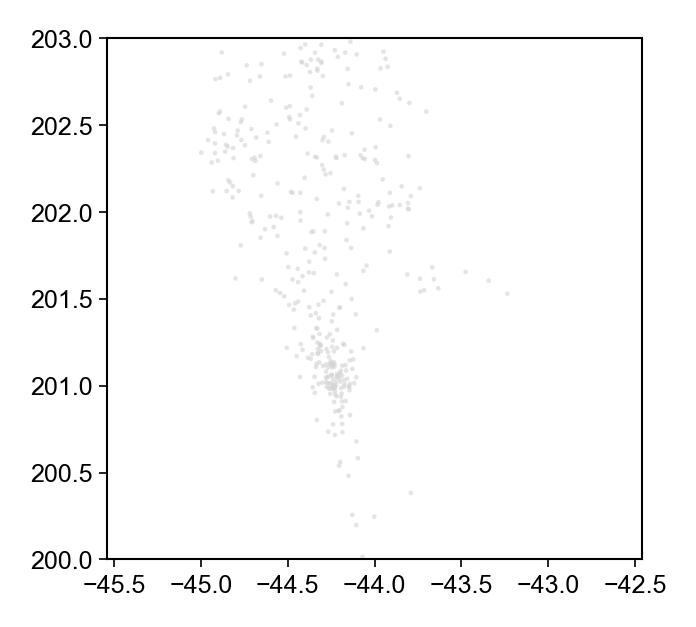

In [26]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

right = -43
left = -45
top = 203
bottom = 200

# manually
s_grey = 5
s_color = 5
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)
ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.grid()

### Select 25 random non-retracted papers

In [27]:
# mask island 1
right = -43
left = -45
top = 203
bottom = 200
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 361 papers in the zoom
There are 361 non-retracted papers in the zoom
Number of retracted papers:  0
Fraction of retracted papers:  0.0


In [80]:
np.random.seed(42)
subset = np.random.choice(
    np.sum(mask_zoom_region_non_retracted), size=25, replace=False
)

In [81]:
clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted].iloc[subset]

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
10038998,25206959,"Proteome analysis of multidrug-resistant, brea...",Cancer multidrug resistance (MDR) occurs when ...,eng,Journal of extracellular vesicles,2014,Deep,Mary,2001-3078,pubmed21n0806.xml
2302083,25330373,Deep sequencing of RNA from three different ex...,Secreted microRNAs (miRNAs) enclosed within ex...,eng,PloS one,2014,Hong,Richard J,1932-6203,pubmed21n0809.xml
1284847,27152724,Epidermal Growth Factor Receptor in Prostate C...,Exosomes proteins and microRNAs have gained mu...,eng,PloS one,2016,Geetanjali,Emma S,1932-6203,pubmed21n0867.xml
19831585,34060205,Lysine demethylase LSD1 delivered via small ex...,Several studies have examined the functions of...,eng,EMBO reports,2021 08 04,Li-Juan,Hong-Min,1469-3178,pubmed22n1087.xml
3719920,30393102,Therapeutic Targeting Cancer-Initiating Cell M...,Transfer of exosomes (Exo) miRNA was described...,eng,Translational oncology,2019 Feb,Daisuke,Margot,1936-5233,pubmed21n0967.xml
11480068,31696667,Upregulation of E-cadherin in bronchoalveolar ...,Lung cancer features extremely high rates of m...,eng,Thoracic cancer,2020 01,Ying,Lingyun,1759-7714,pubmed21n1010.xml
4900967,29306323,Mechanism of recipient cell-dependent differen...,"Exosomes, small-membrane vesicles, are secrete...",eng,BMC cancer,2018 01 06,Sayo,Yoshiyuki,1471-2407,pubmed21n0932.xml
7226928,27941677,The Enrichment of Survivin in Exosomes from Br...,The generation and release of membrane-enclose...,eng,Cancers,2016 Dec 09,Bridget T,Marc A,2072-6694,pubmed21n0890.xml
16870982,25819770,Papillary thyroid cancer-derived exosomes cont...,With the increasing diagnosis of indolent papi...,eng,The Journal of surgical research,2015 Jun 01,James C,Stan,1095-8673,pubmed21n0825.xml
7613616,26675257,Exosomes from bulk and stem cells from human p...,The different prostate cancer (PCa) cell popul...,eng,Oncotarget,2016 Jan 26,Catherine A,Juan C,1949-2553,pubmed21n0852.xml


In [82]:
# Print titles
# One can see much more variation in title style and structure despite them being about similar topic.
for elem in (
    clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted]
    .iloc[subset]
    .Title.to_list()
):
    print(elem)
    print("-----------------------------------")

Proteome analysis of multidrug-resistant, breast cancer-derived microparticles.
-----------------------------------
Deep sequencing of RNA from three different extracellular vesicle (EV) subtypes released from the human LIM1863 colon cancer cell line uncovers distinct miRNA-enrichment signatures.
-----------------------------------
Epidermal Growth Factor Receptor in Prostate Cancer Derived Exosomes.
-----------------------------------
Lysine demethylase LSD1 delivered via small extracellular vesicles promotes gastric cancer cell stemness.
-----------------------------------
Therapeutic Targeting Cancer-Initiating Cell Markers by Exosome miRNA: Efficacy and Functional Consequences Exemplified for claudin7 and EpCAM.
-----------------------------------
Upregulation of E-cadherin in bronchoalveolar lavage fluid-derived exosomes in patients with lung cancer.
-----------------------------------
Mechanism of recipient cell-dependent differences in exosome uptake.
---------------------------